In [19]:
from pathlib import Path

import polars as pl

from plot_functions import bar_plot, distribution_plot, line_plot_variables, violin_plot, scatter_with_regression
from utils.metrics_process import read_metrics, get_assistant_data, aggregate_df

## SETUP

In [20]:
# prompt version (currently only working with 2.0, but nice to be able to easily change)
version = 3.0

In [21]:
metrics_dir = Path.cwd().parents[0] / "metrics"

plots_dir = Path.cwd().parents[0] / "plots" / f"v{version}"

curves_dir = plots_dir / "curves"
barplots_dir = plots_dir / "barplots"
postags_dir = plots_dir / "postags"

for dir in [curves_dir, barplots_dir, postags_dir]:
    dir.mkdir(parents=True, exist_ok=True)

In [22]:
# for giving shorter names in df 
model_dict = {
    "mlx-community--Qwen2.5-7B-Instruct-1M-4bit": "Qwen 2.5 7B Instruct 1M (4bit)",
    "mlx-community--meta-Llama-3.1-8B-Instruct-4bit": "Llama 3.1 8B Instruct (4bit)",
    "meta-llama--Llama-3.1-8B-Instruct": "Llama 3.1 8B Instruct",
    "Qwen--Qwen2.5-7B-Instruct": "Qwen 2.5 7B Instruct",
    "mistralai--Mistral-7B-Instruct-v0.3": "Mistral 7B Instruct v0.3",
}

## TEXT STATS: Load and Process

In [23]:
df = read_metrics(metrics_path=metrics_dir, model_dict=model_dict, version=version, metric_types=["text_stats"])
assistant_df = get_assistant_data(df)

In [24]:
assistant_df

role,content,model,group,id,fernandez_huerta,szigriszt_pazos,gutierrez_polini,crawford,flesch_kincaid_grade,total_message_number
str,str,str,enum,str,f64,f64,f64,f64,f64,i64
"""assistant""","""Hola! ¿Cómo estás hoy? ¡Bienve…","""Mistral 7B Instruct v0.3""","""A1""","""20250322-203105.json""",95.97,91.03,46.98,2.7,7.9,1
"""assistant""","""Hola Delia, un placer conocert…","""Mistral 7B Instruct v0.3""","""A1""","""20250322-203105.json""",95.35,93.7,45.53,2.6,8.1,2
"""assistant""","""Hola Carlos, un placer conocer…","""Mistral 7B Instruct v0.3""","""A1""","""20250322-203105.json""",102.27,98.9,47.92,2.0,6.6,3
"""assistant""","""Hola Carlos, encantado de cono…","""Mistral 7B Instruct v0.3""","""A1""","""20250322-203105.json""",88.33,85.36,44.72,3.3,9.7,4
"""assistant""","""Hola Carlos, me parece que est…","""Mistral 7B Instruct v0.3""","""A1""","""20250322-203105.json""",92.5,86.05,45.08,3.4,9.2,5
…,…,…,…,…,…,…,…,…,…,…
"""assistant""","""¡Qué emocionante! Los senderos…","""Qwen 2.5 7B Instruct""","""C1""","""20250323-021522.json""",85.07,81.23,39.05,3.9,10.9,5
"""assistant""","""Estoy totalmente de acuerdo, l…","""Qwen 2.5 7B Instruct""","""C1""","""20250323-021522.json""",79.77,75.41,38.41,4.4,12.9,6
"""assistant""","""Su análisis del personaje de J…","""Qwen 2.5 7B Instruct""","""C1""","""20250323-021522.json""",70.81,68.96,37.12,4.8,15.3,7


### Plot

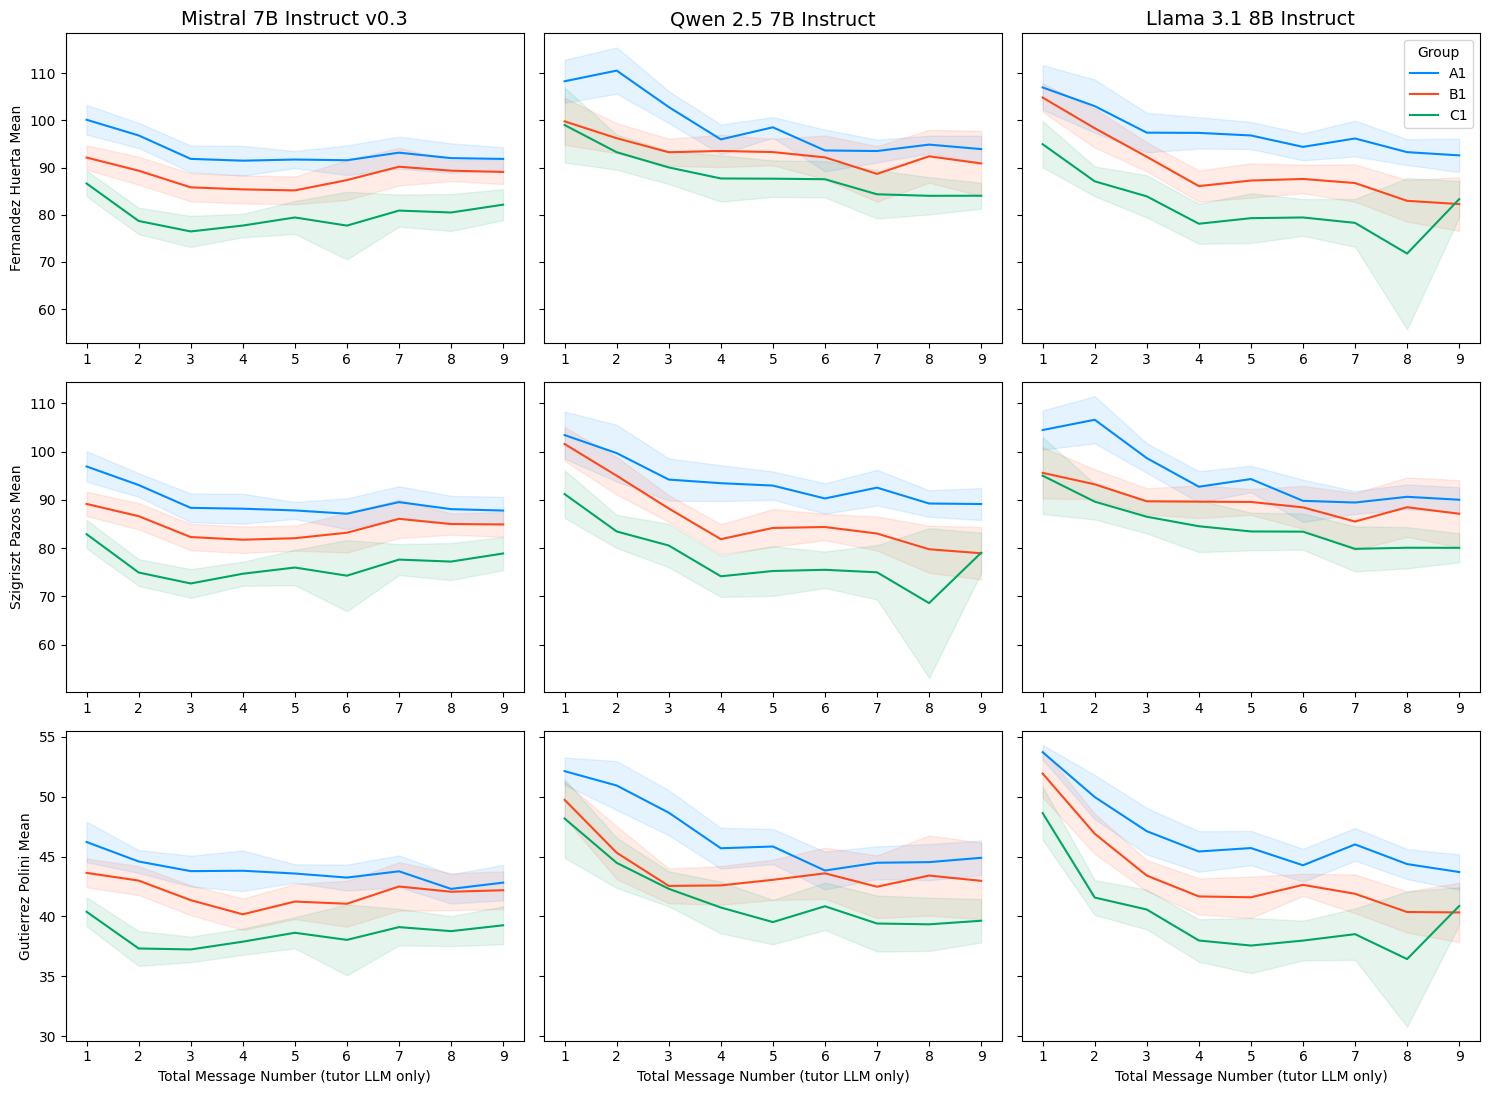

In [25]:
# only take cols 
cols = ["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini", "flesch_kincaid_grade", "crawford"]

# aggregate data
agg_df = aggregate_df(assistant_df, cols_to_aggregate=cols, ci_to_cols=True)

colors = ["#008aff", "#ff471a", "#00a661"]

cols = ["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini"]
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars, 
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "spanish_readability_high_easy.png", dpi=300)

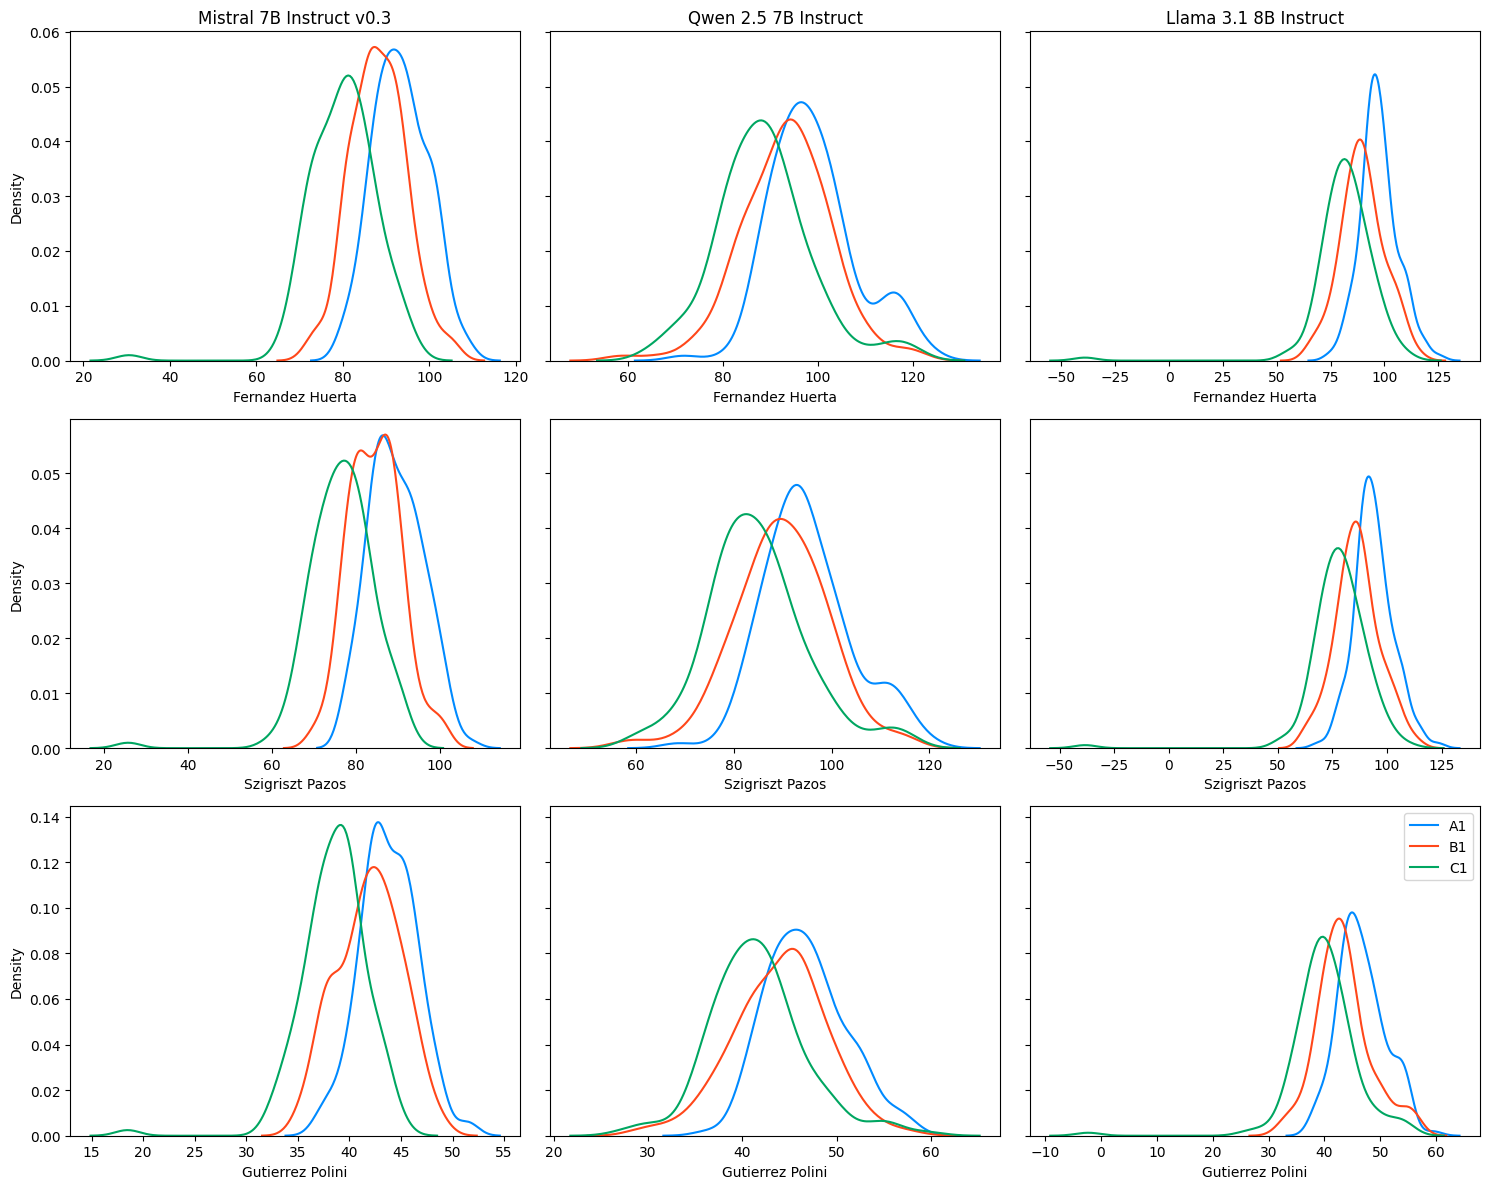

In [26]:
fig = distribution_plot(assistant_df, 
                        x_vars=["fernandez_huerta", "szigriszt_pazos", "gutierrez_polini"], 
                        group_var="group",
                        model_var="model",
                        normalize=True,
                        x_label_texts=["Fernandez Huerta", "Szigriszt Pazos", "Gutierrez Polini"], 
                        density_lines=True)

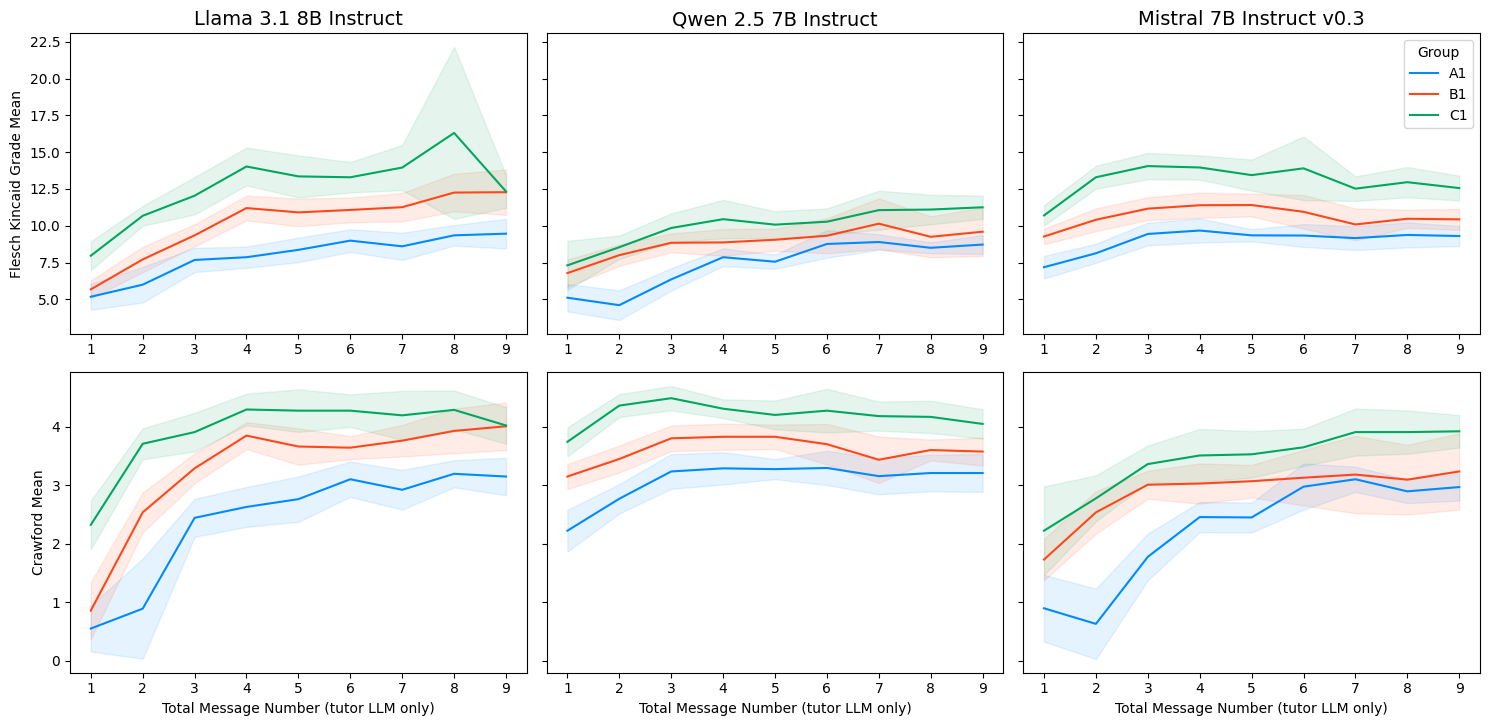

In [27]:
colors = ["#008aff", "#ff471a", "#00a661"]

cols = ["flesch_kincaid_grade", "crawford"]
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars,
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "spanish_readability_high_difficult.png", dpi=300)

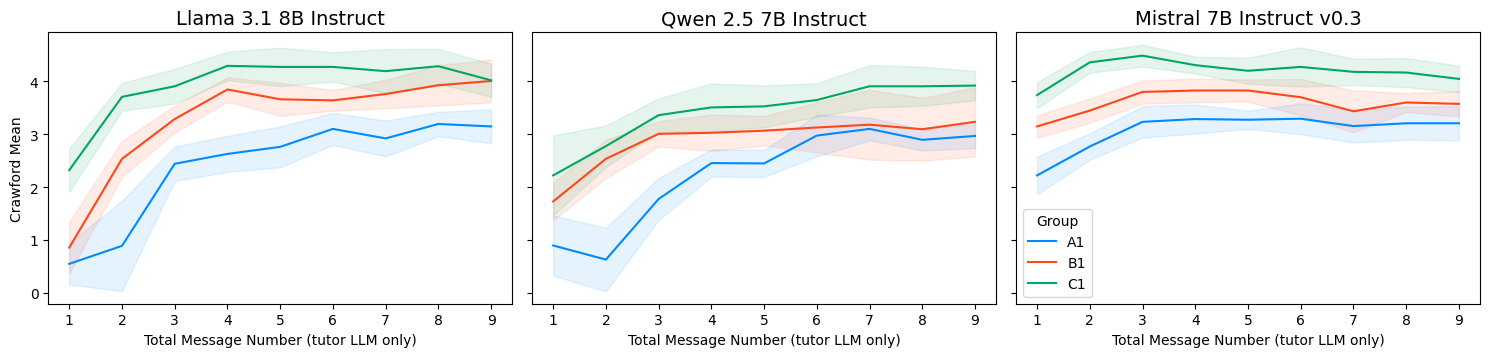

In [28]:
colors = ["#008aff", "#ff471a", "#00a661"]

fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=["crawford_mean"], 
                    ci_vars=["crawford_ci"],
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "crawford.png", dpi=300)

## Dependency Distance, Doc Length, Proportion Unique Tokens

In [29]:
df = read_metrics(metrics_path=metrics_dir, model_dict=model_dict, version=version, metric_types=["textdescriptives"])
assistant_df = get_assistant_data(df)

In [30]:
cols = ["doc_length", "proportion_unique_tokens", "dependency_distance_mean"]
agg_df = aggregate_df(assistant_df, cols_to_aggregate=cols, ci_to_cols=True)

In [43]:
agg_df

model,group,total_message_number,doc_length_mean,proportion_unique_tokens_mean,dependency_distance_mean_mean,doc_length_std,proportion_unique_tokens_std,dependency_distance_mean_std,doc_length_count,proportion_unique_tokens_count,dependency_distance_mean_count,doc_length_ci,doc_length_ci_lower,doc_length_ci_high,proportion_unique_tokens_ci,proportion_unique_tokens_ci_lower,proportion_unique_tokens_ci_high,dependency_distance_mean_ci,dependency_distance_mean_ci_lower,dependency_distance_mean_ci_high
str,enum,i64,f64,f64,f64,f64,f64,f64,u32,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Mistral 7B Instruct v0.3""","""A1""",1,118.933333,0.796513,2.171522,49.242065,0.110719,0.322345,15,15,15,24.919923,94.01341,143.853256,0.056032,0.740481,0.852545,0.163129,2.008393,2.334651
"""Mistral 7B Instruct v0.3""","""A1""",2,177.133333,0.703434,2.59277,70.962633,0.072701,0.248167,15,15,15,35.912047,141.221286,213.04538,0.036792,0.666642,0.740226,0.12559,2.46718,2.718359
"""Mistral 7B Instruct v0.3""","""A1""",3,199.066667,0.676663,2.668782,67.431941,0.063637,0.298916,15,15,15,34.125271,164.941396,233.191937,0.032205,0.644458,0.708868,0.151272,2.517509,2.820054
"""Mistral 7B Instruct v0.3""","""A1""",4,186.066667,0.666214,2.722049,50.714138,0.048403,0.226598,15,15,15,25.664895,160.401772,211.731562,0.024495,0.641718,0.690709,0.114674,2.607375,2.836723
"""Mistral 7B Instruct v0.3""","""A1""",5,180.8,0.675254,2.643427,40.221174,0.040939,0.2266,15,15,15,20.354723,160.445277,201.154723,0.020718,0.654536,0.695972,0.114676,2.528752,2.758103
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Qwen 2.5 7B Instruct""","""C1""",5,188.266667,0.735479,2.453795,177.773719,0.137401,0.2655,15,15,15,89.965915,98.300752,278.232581,0.069534,0.665945,0.805014,0.134362,2.319433,2.588156
"""Qwen 2.5 7B Instruct""","""C1""",6,360.266667,0.645268,2.676614,417.276624,0.178459,0.211976,15,15,15,211.171108,149.095559,571.437774,0.090313,0.554955,0.735581,0.107275,2.569339,2.783888
"""Qwen 2.5 7B Instruct""","""C1""",7,579.066667,0.574757,2.680651,656.523905,0.181713,0.342578,15,15,15,332.246937,246.81973,911.313604,0.09196,0.482797,0.666716,0.173368,2.507283,2.85402


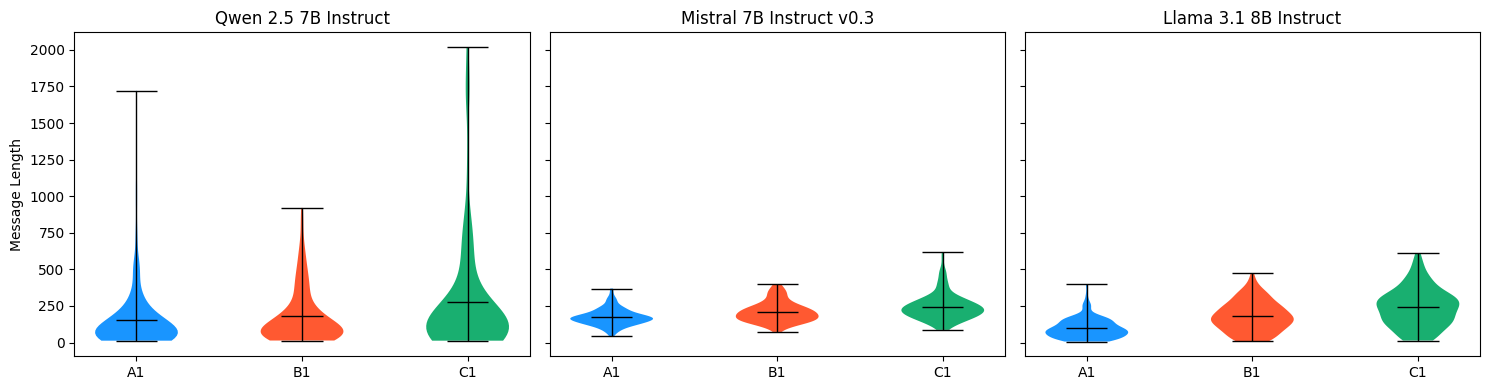

In [31]:
fig = violin_plot(
    assistant_df,  # Use the full dataset
    x_vars=["doc_length"],  # Pass raw values instead of mean
    group_var="group",
    model_var="model",
    y_label_texts=["Message Length"]
)

fig.savefig(plots_dir / "message_length_violin.png", dpi=300)

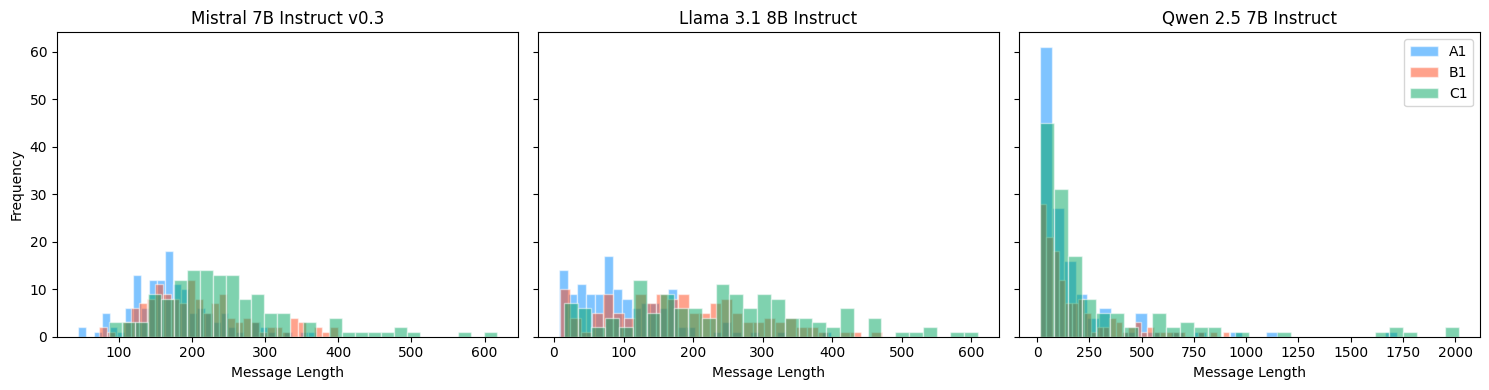

In [32]:
fig = distribution_plot(assistant_df, x_vars=["doc_length"], normalize=False, alpha=0.5, x_label_texts=["Message Length"])

fig.savefig(plots_dir / "message_length_dist.png", dpi=300)

### Unique Tokens

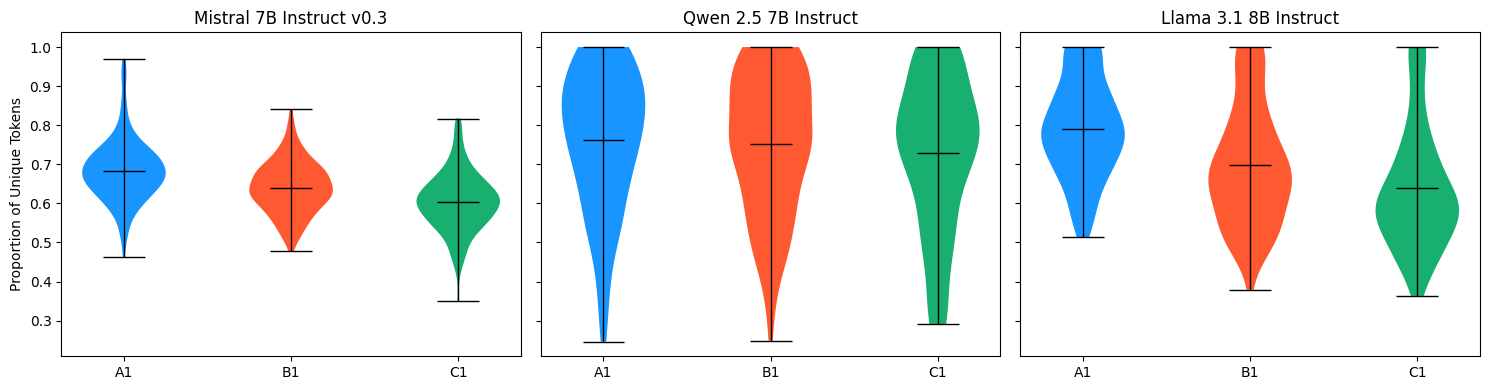

In [33]:
fig = violin_plot(
    assistant_df,  # Use the full dataset
    x_vars=["proportion_unique_tokens"], 
    group_var="group",
    model_var="model",
    y_label_texts=["Proportion of Unique Tokens"]
)

fig.savefig(plots_dir / "unique_tokens_violin.png", dpi=300)

## Length and Unique Tokens over conversation length

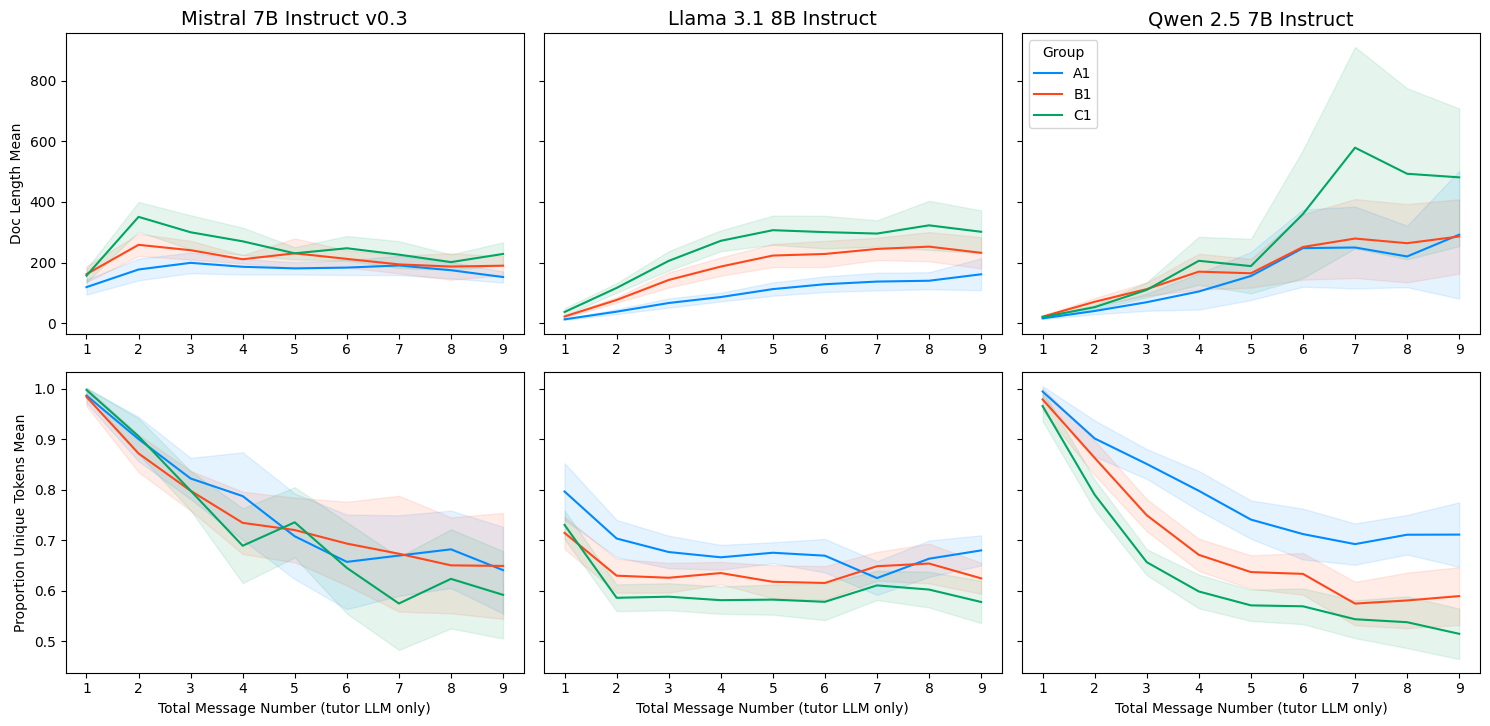

In [36]:
cols = ["doc_length", "proportion_unique_tokens"]
vars = [f"{col}_mean" for col in cols]
ci_vars = [f"{col}_ci" for col in cols]


fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=vars,
                    ci_vars=ci_vars,
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

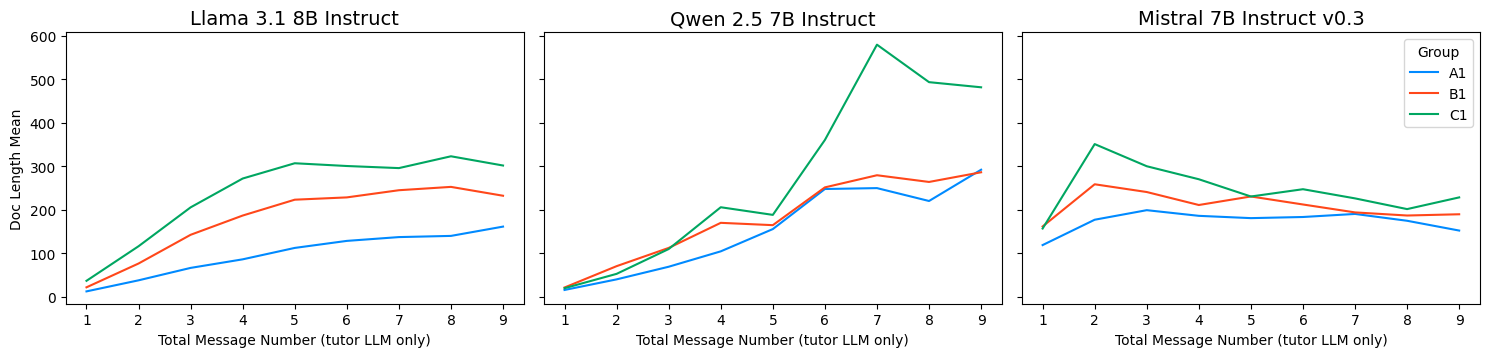

In [37]:
fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=["doc_length_mean"],
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(plots_dir / "curves" / "avg_message_length.png", dpi=300)

### Mean Dependency distance

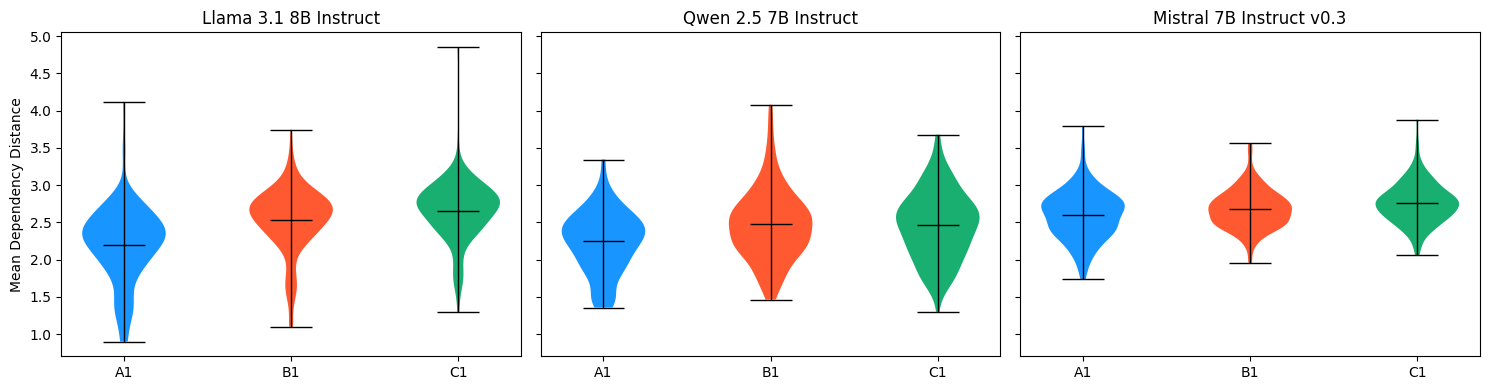

In [47]:
fig = violin_plot(
    assistant_df,  # Use the full dataset
    x_vars=["dependency_distance_mean"], 
    group_var="group",
    model_var="model",
    y_label_texts=["Mean Dependency Distance"]
)

fig.savefig(plots_dir / "mean_dependency_distance_violin.png", dpi=300)

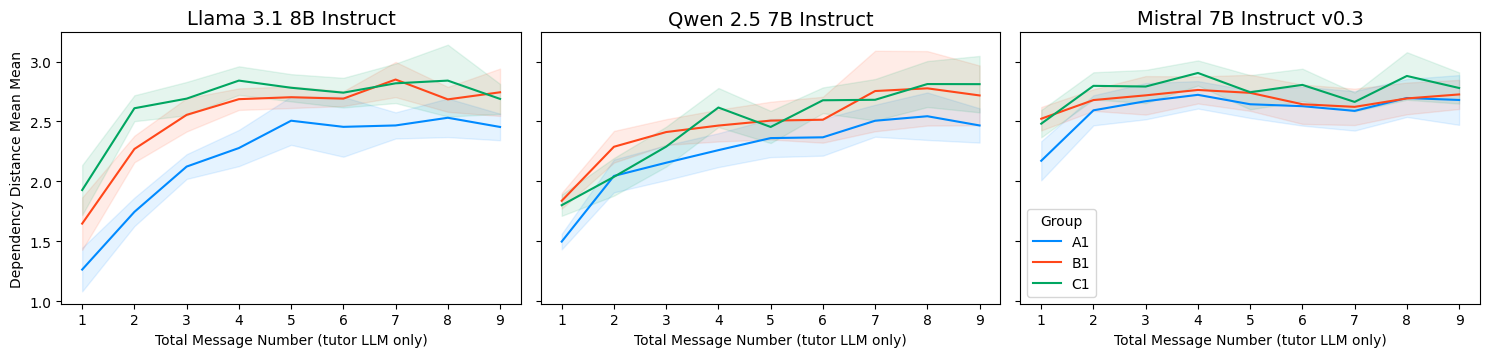

In [49]:
fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=["dependency_distance_mean_mean"], 
                    ci_vars=["dependency_distance_mean_ci"],
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

fig.savefig(curves_dir / "mean_dependency_distance.png", dpi=300)

## Surprisals

In [ ]:
group_levels = pl.Enum(["A1", "B1", "C1"])

surprisal_df = pl.read_csv(metrics_dir / f"v{version}_surprisal.csv", schema_overrides={"group": group_levels}) 

surprisal_df = surprisal_df.with_columns(pl.col("model").replace_strict(model_dict))

In [ ]:
role = "assistant"
filtered_surprisal_df = surprisal_df.filter(pl.col("role") == role)

# assign message numbers
filtered_surprisal_df = filtered_surprisal_df.with_columns(total_message_number=pl.int_range(1, pl.len() + 1).over("id"))

# rename from surprisal_mean to surprisal
filtered_surprisal_df = filtered_surprisal_df.with_columns(
    pl.col("surprisal_mean").alias("surprisal_paragraph")
)

cols = ["surprisal_paragraph"]
# compute average scores
agg_df = (
    filtered_surprisal_df.group_by(["model", "group", "total_message_number"], maintain_order=True)
    .agg([
        *[pl.col(col).mean().alias(f"{col}_mean") for col in cols],
        *[pl.col(col).std().alias(f"{col}_std") for col in cols],
        *[pl.col(col).count().alias(f"{col}_count") for col in cols],
    ])
)

# apply ci
for col in cols:
    agg_df = add_ci_to_col(agg_df, col)

In [ ]:
fig = line_plot_variables(df=agg_df, 
                    x_var="total_message_number", 
                    y_vars=["surprisal_paragraph_mean"],
                    ci_vars=["surprisal_paragraph_ci"],
                    group_var="group",
                    model_var="model", 
                    x_label_text="Total Message Number (tutor LLM only)", 
                    group_colors=colors)

In [ ]:
# distribution plot
fig = distribution_plot(filtered_surprisal_df, 
                        x_vars=["surprisal_paragraph"], 
                        normalize=True,
                        alpha=0.5, 
                        x_label_texts=["Surprisal"], 
                        density_lines=True)